# $\color{355834}{\text{Firing patterns in the AdEx model}}$

_This notebook is inspired to the analysis on the multiple firing pattern in the AdEx neuron model in [1](https://neuronaldynamics.epfl.ch/online/Ch6.S1.html) ._

Cortical neurons express a variety of firing patterns. Such variability is motivated by different input conditions and biological properties of the cell's membrane. 

In the following I will investigate the impact of a subset of parameters on the firing pattern (FP) of a neuron model and what it takes to reproduce the FP observed in the lab.

### $\color{847996}{\text{Methods}}$

The employed AdEx neuron equation is taken from _Brette et al., 2005_ [2](https://journals.physiology.org/doi/full/10.1152/jn.00686.2005).

\begin{equation}
\tau \frac{dv}{dt} =  -(v-v0) + R * I - w
\end{equation}

where the following parameters have biological interpretations (Table 1):

Parameter | Dim | Name | Meaning 
---|:---|:---:|:---:|
$\tau$| ms |Membrane timescale | The time constant that modulate the integration of the neuron equation.
$\frac{dv}{dt}$| $\frac{mV}{ms}$ | - | The rate of change of the membrane potential over time.
v| mV | Membrane potential | The electrical potential across the neuron's membrane at a given time.
v0| mV | Resting potential | The membrane potential of the neuron at rest (no stimuli/inputs).
R| Ω | Membrane resistance | The sensitivity of the neuron's membrane potential to the input current.
I| pA | Input current | The current injected into the neuron.
w| mV | Adaptation current | It captures the dynamics of the adaptation process in the AdEx model, with a crucial role in spike frequency adaptation.

_Table 1: Description of the parameters of the AdEx neuron equation (1)._

#### $\color{C2A878}{\text{Dimensional Analysis of the equation}}$

\begin{equation}
\tau\frac{dv}{dt} =  -(v-v0) + R * I - w
\tag{1}
\end{equation}



\begin{equation}
\frac{[ms][mV]}{[ms]} = -([mV]-[mV])+([GΩ]*[pA])-[mV]
\tag{2}
\end{equation}

\begin{equation}
[mV]= [mV] + [mV] -[mV]
\tag{3}
\end{equation}

\begin{equation}
[mV]= [mV]
\tag{4}
\end{equation}

## $\color{847996}{\text{Simulation}}$

The simulation is carried out with the _SpikingNeuralNetworks.jl_ package in _JuliaLanguage_. 

The package works like the following....

1. Import all the necessary packages and modules:

In [1]:
using Revise
using DrWatson
using Logging
@quickactivate "SNNExamples"

using SpikingNeuralNetworks
using Plots
using ColorSchemes

default(
    size=(800, 600),
    tickfontsize=10,
    guidefontsize=10,
    margin=5Plots.mm,
    titlefontsize=13,
    titlefontcolor=:tan2,
    legend=:outertopright,
    palette= (:Dark2_5),
)

SNN.@load_units
const pA = ampere / 1e12

1.0e-6

2. Define 'initialize_pop' function: takes a parameter firing_pattern and initializes the AdEx neuron with specific parameters for each firing pattern.

In [2]:
#AdEx neuron
function initialize_pop(firing_pattern)
    if firing_pattern == "tonic"
        param = SNN.AdExParameter(;El=-70mV, τm=20ms, τe=30ms, a=0.0nS, b=60pA, Vr=-55mV, Vt=-50mV, ΔT=2mV)
    elseif firing_pattern == "adapting"
        param = SNN.AdExParameter(;El=-70mV, τm=20ms, τe=100ms, a=0.0nS, b=50nA, Vr=-55mV, Vt=-50mV, ΔT=2mV)
    elseif firing_pattern == "bursting"
        param = SNN.AdExParameter(;El=-70mV, τm=5.0ms, τe=100ms, a=-0.5nS, b=70nA, Vr=-46, Vt=-50mV, ΔT=2mV)
    else
        error("Invalid firing pattern")
    end

    E = SNN.AdEx(;N=1, param=param)
    SNN.monitor(E, [:v, :fire, :w])
    return E
end

initialize_pop (generic function with 1 method)

3. Create an AdEx neuron E1 for the tonic firing pattern using initialize_pop("tonic"). 
- The input current I of E1 is set to 40 pA. 
- _SNN.sim!_ function is called to simulate the spiking behavior of E1 for a duration of 200 ms. 
- The membrane potential and synaptic weights of E1 are plotted using _SNN.vecplot_. 
- The resulting plot p1 is labeled as "Tonic firing".

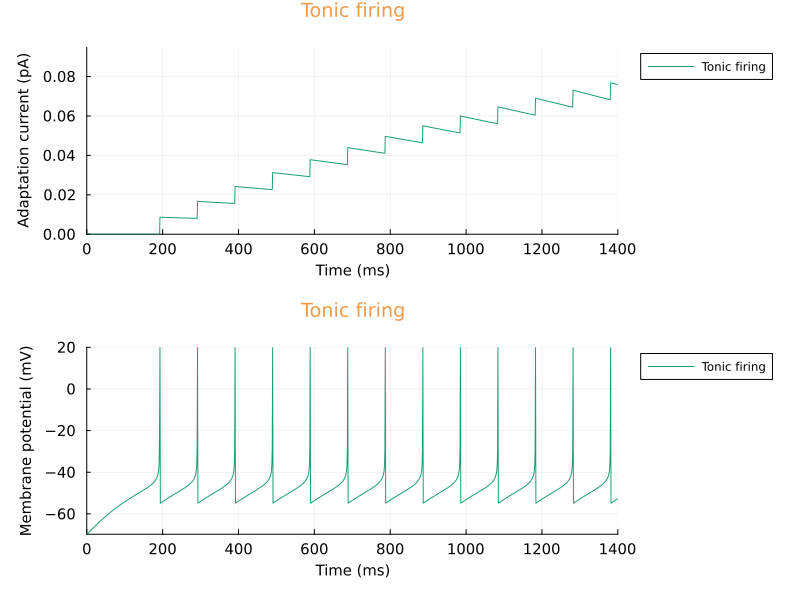

In [3]:
#Tonic firing:
"neuron fires at a const. rate in response to steady input current. 
=> AdEx neuron generates series of action potentials separated by constant intervals."

E1 = initialize_pop("tonic")
E1.I = [40]
E1.v .= -70mV
SNN.sim!([E1], []; duration = 200ms)

p1_w = plot(SNN.vecplot(E1, :w), linewidth=2, color=:green, ylabel="Adaptation current (pA)", xlims=(0,1400))
p1_v = plot(SNN.vecplot(E1, :v), color=:red, ylabel="Membrane potential (mV)", xlims=(0,1400))
layout = grid(2, 1)
p1= plot(p1_w, p1_v, layout=layout, title="Tonic firing", xlabel="Time (ms)", legend=:outertopright, label="Tonic firing")


In [4]:
using Logging
 for x in fieldnames(SNN.AdExParameter)
     println(x, "  ",  getfield(E1.param, x))
 end

τm  

20.0
τe  30.0
τi  10.0
Vt  -50.0
Vr  -55.0
El  -70.0
R  0.5
ΔT  2.0
τw  144.0
a  0.0
b  6.0e-5


4. AdEx neuron E2 is created, where the input current I is set to 65 pA, and the simulation is run for 200 ms. 
The resulting plot p2 is labeled as "Adapting firing".

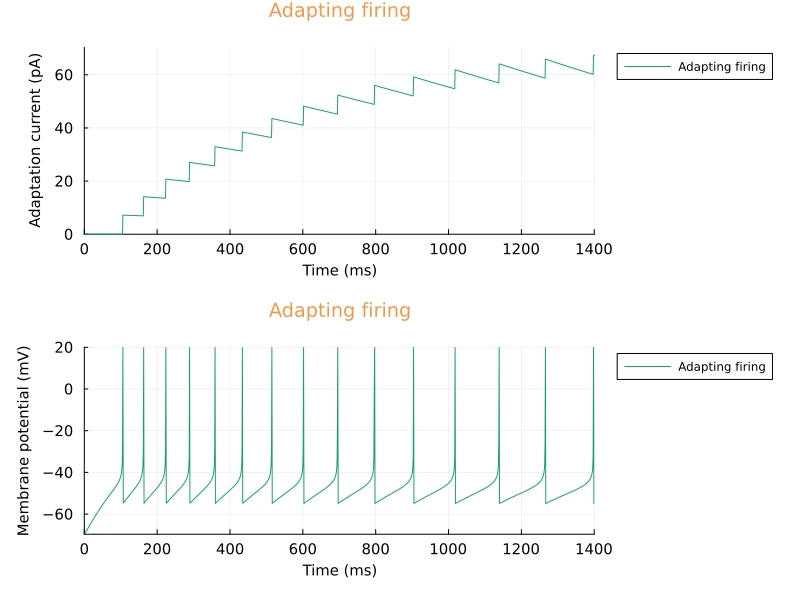

In [5]:
#Adapting firing:
"neuron initially generates a high-frequency burst of action potentials 
in response to a current stimulus, then firing rate slows down and becomes more irregular over time. 
=> observed as a progressive decrease in the instantaneous firing rate in response to const. current input."

E2 = initialize_pop("adapting")
E2.I = [65]
E2.v .= -70mV
SNN.sim!([E2], []; duration = 200ms)

p2_w = plot(SNN.vecplot(E2, :w), ylabel="Adaptation current (pA)", xlims=(0,1400))
p2_v = plot(SNN.vecplot(E2, :v), ylabel="Membrane potential (mV)", xlims=(0,1400))
layout = grid(2, 1)
p2= plot(p2_w, p2_v, layout=layout, title="Adapting firing", xlabel="Time (ms)", legend=:outertopright, label="Adapting firing")



6. The _Logging_ function and the _for loop_ created retrieve and print out the values of the AdEx neuron parameters.

In [6]:
using Logging
 for x in fieldnames(SNN.AdExParameter)
     println(x, "  ",  getfield(E2.param, x))
 end

τm  20.0
τe  100.0
τi  10.0
Vt  -50.0
Vr  -55.0
El  -70.0
R  0.5
ΔT  2.0
τw  144.0
a  0.0
b  0.05


7. Create AdEx neuron E3 where the input current I is set to a pattern of values, and the simulation is run for 200 ms. 
The resulting plot p3 is labeled as "Bursting firing".

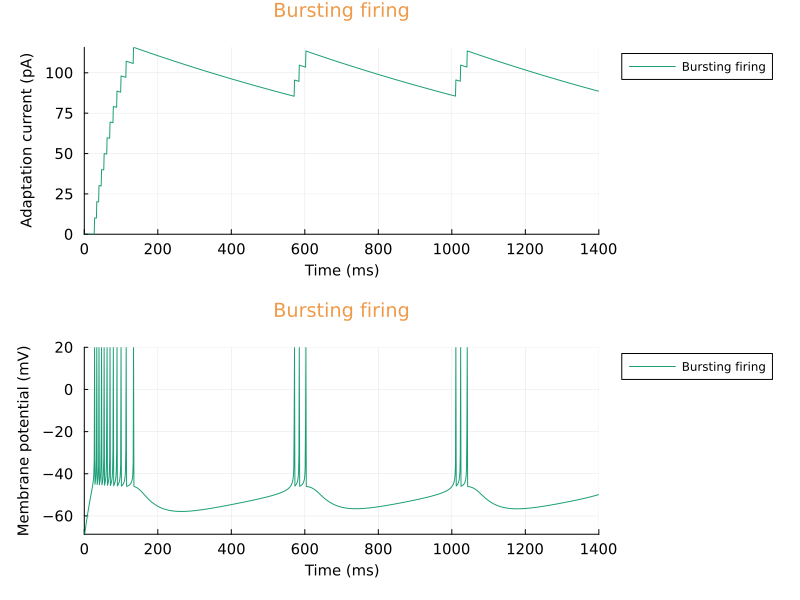

In [7]:
#Bursting firing:
"neuron generates a series of high-frequency action potentials separated by resting periods. 
=> observed as a series of spikes followed by a period of silence/low-level activity. 
=> can be classified into different subtypes based on the number and duration of the bursts."

E3 = initialize_pop("bursting")
E3.I = [65,-65,65,-65,65,-65,65,-65]
E3.v .= -70mV
SNN.sim!([E3], []; duration = 200ms)

p3_w = plot(SNN.vecplot(E3, :w), ylabel="Adaptation current (pA)", xlims=(0,1400))
p3_v = plot(SNN.vecplot(E3, :v), ylabel="Membrane potential (mV)", xlims=(0,1400))
layout = grid(2, 1)
p3= plot(p3_w, p3_v, layout=layout, title="Bursting firing", xlabel="Time (ms)", legend=:outertopright, label="Bursting firing")



In [8]:

using Logging
for x in fieldnames(SNN.AdExParameter)
    println(x, "  ",  getfield(E3.param, x))
end




τm  5.0
τe  100.0
τi  10.0
Vt  -50.0
Vr  -46.0
El  -70.0
R  0.5
ΔT  2.0
τw  144.0
a  -5.0e-7
b  0.07


8. The obtained plots p1, p2, and p3 are combined into a single plot using _Plot_ function. 

- The layout is set to a 3x1 grid, and the legend is positioned in the top-right corner. 
- The x-axis is labeled as "Time (ms)", and the y-axis as "Membrane Potential (mV)" and "Adaptation current (pA)". 
- The title of the plot is set to "Multiple Firing Patterns in AdEx Neuron Model".

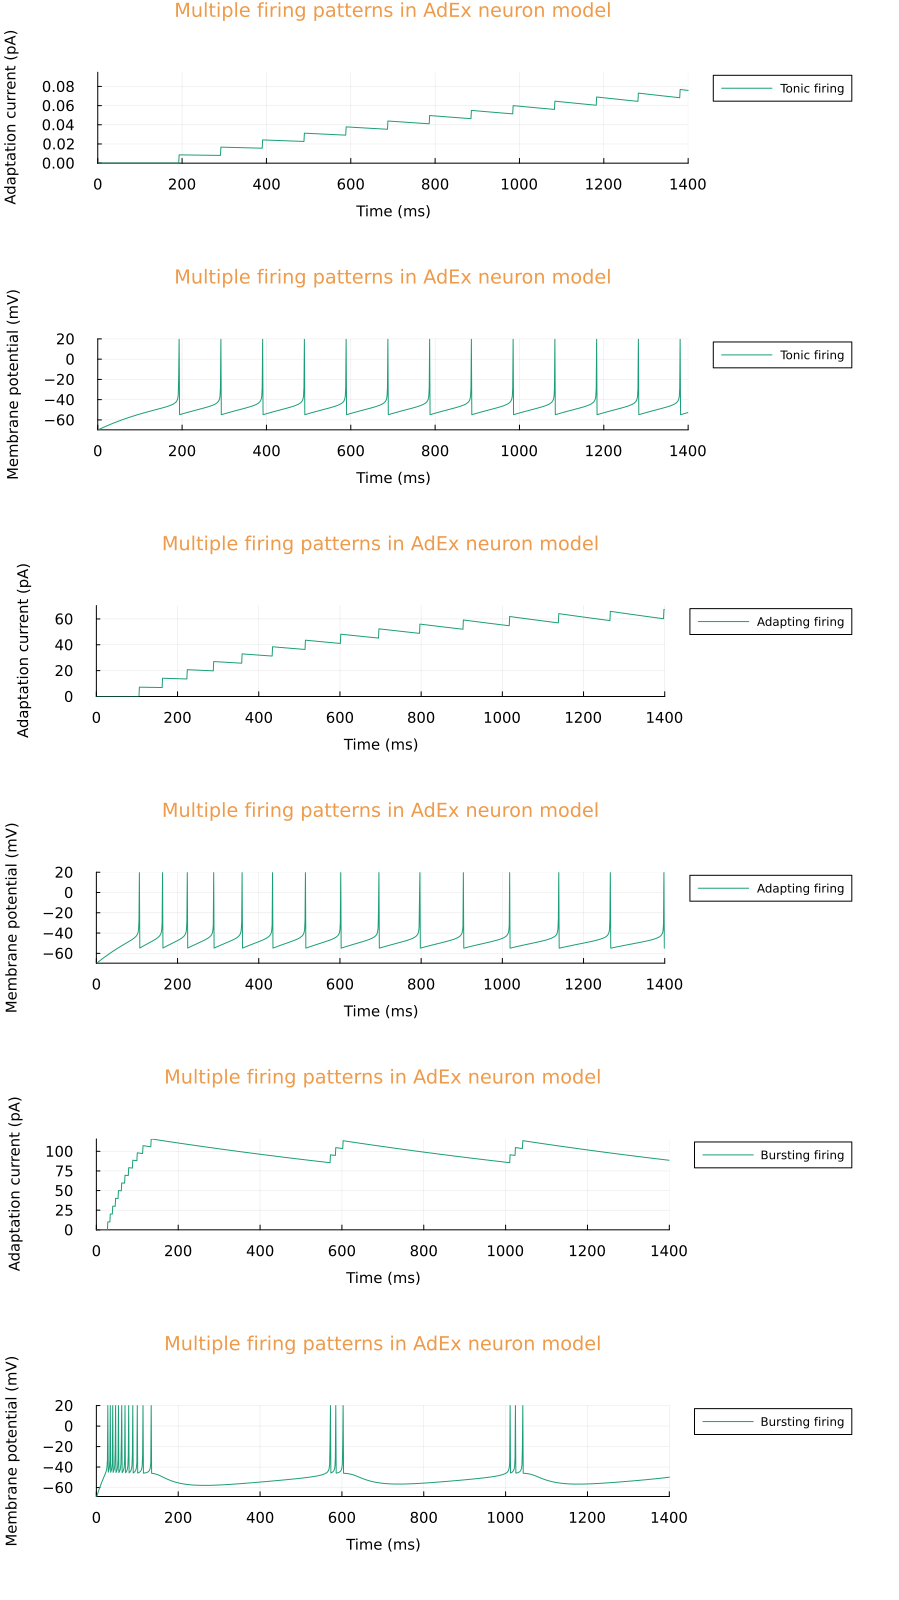

In [9]:

plot(p1, p2, p3, 
layout=(3, 1), 
legend=true,
size=(900, 1600),
xlabel="Time (ms)",
margin=10Plots.mm,
title="Multiple firing patterns in AdEx neuron model"
)
plot!(; legend=:outertopright)
